<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:13:01] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


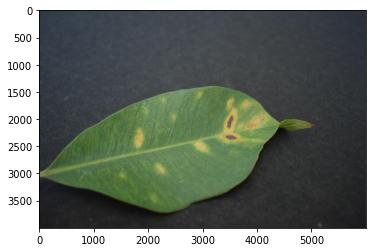

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

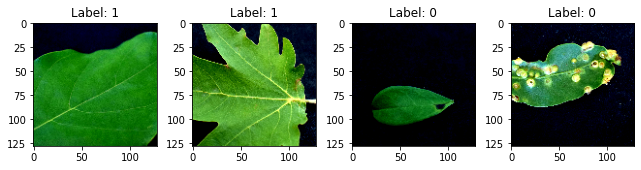

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:13:08] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:13:10] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2602584634614633 samples/sec                   batch loss = 1.4834789037704468 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2684574744087067 samples/sec                   batch loss = 0.7974597215652466 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2709193726161574 samples/sec                   batch loss = 0.548109769821167 | accuracy = 0.5666666666666667


Epoch[1] Batch[20] Speed: 1.269361908147864 samples/sec                   batch loss = 0.8960791826248169 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.2494543714849542 samples/sec                   batch loss = 0.47938302159309387 | accuracy = 0.6


Epoch[1] Batch[30] Speed: 1.2617932756918508 samples/sec                   batch loss = 0.698451042175293 | accuracy = 0.5666666666666667


Epoch[1] Batch[35] Speed: 1.2650372324234136 samples/sec                   batch loss = 0.6379595398902893 | accuracy = 0.5857142857142857


Epoch[1] Batch[40] Speed: 1.2586897011593872 samples/sec                   batch loss = 0.2967761754989624 | accuracy = 0.58125


Epoch[1] Batch[45] Speed: 1.25753077114269 samples/sec                   batch loss = 0.6650344729423523 | accuracy = 0.5722222222222222


Epoch[1] Batch[50] Speed: 1.261412849915006 samples/sec                   batch loss = 0.676929235458374 | accuracy = 0.575


Epoch[1] Batch[55] Speed: 1.2708417792434525 samples/sec                   batch loss = 0.6674019694328308 | accuracy = 0.5909090909090909


Epoch[1] Batch[60] Speed: 1.2668515056514125 samples/sec                   batch loss = 0.8418943285942078 | accuracy = 0.6041666666666666


Epoch[1] Batch[65] Speed: 1.2669951079680861 samples/sec                   batch loss = 0.8166759014129639 | accuracy = 0.6038461538461538


Epoch[1] Batch[70] Speed: 1.2664734735084593 samples/sec                   batch loss = 0.5090631246566772 | accuracy = 0.6107142857142858


Epoch[1] Batch[75] Speed: 1.2678308665724376 samples/sec                   batch loss = 0.2386503666639328 | accuracy = 0.63


Epoch[1] Batch[80] Speed: 1.2675500191146227 samples/sec                   batch loss = 0.42080065608024597 | accuracy = 0.628125


Epoch[1] Batch[85] Speed: 1.2622701278971573 samples/sec                   batch loss = 0.5488995909690857 | accuracy = 0.6323529411764706


Epoch[1] Batch[90] Speed: 1.2667595828181077 samples/sec                   batch loss = 0.7073521614074707 | accuracy = 0.6333333333333333


Epoch[1] Batch[95] Speed: 1.2745298251864727 samples/sec                   batch loss = 0.6337934732437134 | accuracy = 0.6368421052631579


Epoch[1] Batch[100] Speed: 1.267302321474285 samples/sec                   batch loss = 0.6000956892967224 | accuracy = 0.6325


Epoch[1] Batch[105] Speed: 1.2637167467015324 samples/sec                   batch loss = 0.34289729595184326 | accuracy = 0.638095238095238


Epoch[1] Batch[110] Speed: 1.2588571507035275 samples/sec                   batch loss = 0.5667764544487 | accuracy = 0.65


Epoch[1] Batch[115] Speed: 1.266513150067609 samples/sec                   batch loss = 0.46775487065315247 | accuracy = 0.6413043478260869


Epoch[1] Batch[120] Speed: 1.2702281051063316 samples/sec                   batch loss = 0.3721100687980652 | accuracy = 0.6375


Epoch[1] Batch[125] Speed: 1.2619677221140277 samples/sec                   batch loss = 0.5617982149124146 | accuracy = 0.634


Epoch[1] Batch[130] Speed: 1.2644342959726964 samples/sec                   batch loss = 0.5809543132781982 | accuracy = 0.6403846153846153


Epoch[1] Batch[135] Speed: 1.2680206910620015 samples/sec                   batch loss = 0.6179991364479065 | accuracy = 0.6407407407407407


Epoch[1] Batch[140] Speed: 1.2689195112109641 samples/sec                   batch loss = 0.7295302748680115 | accuracy = 0.6392857142857142


Epoch[1] Batch[145] Speed: 1.2652673464094797 samples/sec                   batch loss = 1.1511762142181396 | accuracy = 0.6413793103448275


Epoch[1] Batch[150] Speed: 1.2615719177721665 samples/sec                   batch loss = 0.7717083096504211 | accuracy = 0.6416666666666667


Epoch[1] Batch[155] Speed: 1.2651375869370287 samples/sec                   batch loss = 1.080622673034668 | accuracy = 0.6387096774193548


Epoch[1] Batch[160] Speed: 1.271179369835924 samples/sec                   batch loss = 0.477130651473999 | accuracy = 0.6421875


Epoch[1] Batch[165] Speed: 1.2667888512841352 samples/sec                   batch loss = 1.1020872592926025 | accuracy = 0.6393939393939394


Epoch[1] Batch[170] Speed: 1.2667312721247583 samples/sec                   batch loss = 0.42438554763793945 | accuracy = 0.6426470588235295


Epoch[1] Batch[175] Speed: 1.2635816901786088 samples/sec                   batch loss = 0.8843979239463806 | accuracy = 0.6442857142857142


Epoch[1] Batch[180] Speed: 1.2628484728552043 samples/sec                   batch loss = 0.5927339792251587 | accuracy = 0.65


Epoch[1] Batch[185] Speed: 1.2611397679223002 samples/sec                   batch loss = 0.5861414670944214 | accuracy = 0.6527027027027027


Epoch[1] Batch[190] Speed: 1.2669802774407162 samples/sec                   batch loss = 0.9806448817253113 | accuracy = 0.6539473684210526


Epoch[1] Batch[195] Speed: 1.2637889980889363 samples/sec                   batch loss = 0.6963135004043579 | accuracy = 0.6551282051282051


Epoch[1] Batch[200] Speed: 1.2684914249586632 samples/sec                   batch loss = 0.45439088344573975 | accuracy = 0.65875


Epoch[1] Batch[205] Speed: 1.262827940948556 samples/sec                   batch loss = 0.42548298835754395 | accuracy = 0.6585365853658537


Epoch[1] Batch[210] Speed: 1.2622942506423496 samples/sec                   batch loss = 0.3019068241119385 | accuracy = 0.6571428571428571


Epoch[1] Batch[215] Speed: 1.2707425389998264 samples/sec                   batch loss = 0.526027262210846 | accuracy = 0.6616279069767442


Epoch[1] Batch[220] Speed: 1.2705296723587207 samples/sec                   batch loss = 1.6283117532730103 | accuracy = 0.6602272727272728


Epoch[1] Batch[225] Speed: 1.267932910533245 samples/sec                   batch loss = 0.3511446714401245 | accuracy = 0.6611111111111111


Epoch[1] Batch[230] Speed: 1.266420511566308 samples/sec                   batch loss = 0.8592800498008728 | accuracy = 0.6630434782608695


Epoch[1] Batch[235] Speed: 1.2680153242179797 samples/sec                   batch loss = 0.6526476740837097 | accuracy = 0.6606382978723404


Epoch[1] Batch[240] Speed: 1.2645680097733107 samples/sec                   batch loss = 0.38356614112854004 | accuracy = 0.6604166666666667


Epoch[1] Batch[245] Speed: 1.264802911308581 samples/sec                   batch loss = 0.5607099533081055 | accuracy = 0.6642857142857143


Epoch[1] Batch[250] Speed: 1.2654994532482156 samples/sec                   batch loss = 0.4530853033065796 | accuracy = 0.662


Epoch[1] Batch[255] Speed: 1.2659869447390268 samples/sec                   batch loss = 0.9103984236717224 | accuracy = 0.6627450980392157


Epoch[1] Batch[260] Speed: 1.2710863363879823 samples/sec                   batch loss = 0.5320539474487305 | accuracy = 0.6567307692307692


Epoch[1] Batch[265] Speed: 1.2795690904262436 samples/sec                   batch loss = 0.2266855537891388 | accuracy = 0.660377358490566


Epoch[1] Batch[270] Speed: 1.265967552500531 samples/sec                   batch loss = 0.7922828197479248 | accuracy = 0.6601851851851852


Epoch[1] Batch[275] Speed: 1.2778550652092233 samples/sec                   batch loss = 0.2908254861831665 | accuracy = 0.6636363636363637


Epoch[1] Batch[280] Speed: 1.2736187881897576 samples/sec                   batch loss = 0.43669214844703674 | accuracy = 0.6598214285714286


Epoch[1] Batch[285] Speed: 1.2675838253339273 samples/sec                   batch loss = 0.7298499345779419 | accuracy = 0.6578947368421053


Epoch[1] Batch[290] Speed: 1.2688732539982002 samples/sec                   batch loss = 0.5781762003898621 | accuracy = 0.6586206896551724


Epoch[1] Batch[295] Speed: 1.2716315367534075 samples/sec                   batch loss = 0.7031019926071167 | accuracy = 0.6576271186440678


Epoch[1] Batch[300] Speed: 1.2683606198338142 samples/sec                   batch loss = 0.4342218041419983 | accuracy = 0.6591666666666667


Epoch[1] Batch[305] Speed: 1.2680279747086962 samples/sec                   batch loss = 0.3721901476383209 | accuracy = 0.659016393442623


Epoch[1] Batch[310] Speed: 1.26673710631953 samples/sec                   batch loss = 0.3265356123447418 | accuracy = 0.6629032258064517


Epoch[1] Batch[315] Speed: 1.2625314434159987 samples/sec                   batch loss = 0.2632880210876465 | accuracy = 0.6634920634920635


Epoch[1] Batch[320] Speed: 1.265230514912854 samples/sec                   batch loss = 0.5977575182914734 | accuracy = 0.665625


Epoch[1] Batch[325] Speed: 1.2658529307132318 samples/sec                   batch loss = 0.7025231122970581 | accuracy = 0.6638461538461539


Epoch[1] Batch[330] Speed: 1.2641637145153166 samples/sec                   batch loss = 0.7091533541679382 | accuracy = 0.6628787878787878


Epoch[1] Batch[335] Speed: 1.263190103860793 samples/sec                   batch loss = 0.6826156377792358 | accuracy = 0.6626865671641791


Epoch[1] Batch[340] Speed: 1.2627483861158926 samples/sec                   batch loss = 0.3420426845550537 | accuracy = 0.6617647058823529


Epoch[1] Batch[345] Speed: 1.2661808042457756 samples/sec                   batch loss = 0.419594407081604 | accuracy = 0.6623188405797101


Epoch[1] Batch[350] Speed: 1.2650341800641414 samples/sec                   batch loss = 0.47060367465019226 | accuracy = 0.6628571428571428


Epoch[1] Batch[355] Speed: 1.2641637145153166 samples/sec                   batch loss = 0.33993884921073914 | accuracy = 0.6654929577464789


Epoch[1] Batch[360] Speed: 1.262898189450205 samples/sec                   batch loss = 0.5834143161773682 | accuracy = 0.6659722222222222


Epoch[1] Batch[365] Speed: 1.2650365647185642 samples/sec                   batch loss = 0.43644198775291443 | accuracy = 0.6678082191780822


Epoch[1] Batch[370] Speed: 1.2631733650559411 samples/sec                   batch loss = 0.544651448726654 | accuracy = 0.668918918918919


Epoch[1] Batch[375] Speed: 1.2672311993032848 samples/sec                   batch loss = 0.9945444464683533 | accuracy = 0.6673333333333333


Epoch[1] Batch[380] Speed: 1.2670614190240588 samples/sec                   batch loss = 0.8879455327987671 | accuracy = 0.6644736842105263


Epoch[1] Batch[385] Speed: 1.2635990108249207 samples/sec                   batch loss = 0.45058348774909973 | accuracy = 0.6649350649350649


Epoch[1] Batch[390] Speed: 1.267857501815574 samples/sec                   batch loss = 0.308024138212204 | accuracy = 0.6653846153846154


Epoch[1] Batch[395] Speed: 1.2684366638118325 samples/sec                   batch loss = 0.5175114870071411 | accuracy = 0.6670886075949367


Epoch[1] Batch[400] Speed: 1.2690004214567154 samples/sec                   batch loss = 0.6201831698417664 | accuracy = 0.668125


Epoch[1] Batch[405] Speed: 1.2672475672249297 samples/sec                   batch loss = 0.48978331685066223 | accuracy = 0.6703703703703704


Epoch[1] Batch[410] Speed: 1.266715491375392 samples/sec                   batch loss = 0.5990495681762695 | accuracy = 0.6713414634146342


Epoch[1] Batch[415] Speed: 1.2652743121927073 samples/sec                   batch loss = 1.2177540063858032 | accuracy = 0.6692771084337349


Epoch[1] Batch[420] Speed: 1.2661166874098742 samples/sec                   batch loss = 0.6197580695152283 | accuracy = 0.669047619047619


Epoch[1] Batch[425] Speed: 1.2697294626344326 samples/sec                   batch loss = 0.46340441703796387 | accuracy = 0.67


Epoch[1] Batch[430] Speed: 1.264336911417749 samples/sec                   batch loss = 0.508475661277771 | accuracy = 0.6703488372093023


Epoch[1] Batch[435] Speed: 1.2600423753922607 samples/sec                   batch loss = 0.539350688457489 | accuracy = 0.6718390804597701


Epoch[1] Batch[440] Speed: 1.2680405296119213 samples/sec                   batch loss = 0.5828440189361572 | accuracy = 0.6732954545454546


Epoch[1] Batch[445] Speed: 1.266566980313543 samples/sec                   batch loss = 0.4468347430229187 | accuracy = 0.6741573033707865


Epoch[1] Batch[450] Speed: 1.2635847355325667 samples/sec                   batch loss = 0.5290532112121582 | accuracy = 0.6744444444444444


Epoch[1] Batch[455] Speed: 1.265654588547984 samples/sec                   batch loss = 0.38741564750671387 | accuracy = 0.6747252747252748


Epoch[1] Batch[460] Speed: 1.2578270932482687 samples/sec                   batch loss = 0.8280472755432129 | accuracy = 0.6733695652173913


Epoch[1] Batch[465] Speed: 1.256167491834118 samples/sec                   batch loss = 0.5616734623908997 | accuracy = 0.6741935483870968


Epoch[1] Batch[470] Speed: 1.2659735707178659 samples/sec                   batch loss = 0.35842788219451904 | accuracy = 0.675


Epoch[1] Batch[475] Speed: 1.27140883349874 samples/sec                   batch loss = 0.47247758507728577 | accuracy = 0.6752631578947368


Epoch[1] Batch[480] Speed: 1.2705870200040092 samples/sec                   batch loss = 0.9428060054779053 | accuracy = 0.675


Epoch[1] Batch[485] Speed: 1.2608668989010752 samples/sec                   batch loss = 0.7027603387832642 | accuracy = 0.6737113402061856


Epoch[1] Batch[490] Speed: 1.262157409021379 samples/sec                   batch loss = 0.596596896648407 | accuracy = 0.6724489795918367


Epoch[1] Batch[495] Speed: 1.2611153100975496 samples/sec                   batch loss = 0.6171661019325256 | accuracy = 0.6722222222222223


Epoch[1] Batch[500] Speed: 1.264616622654022 samples/sec                   batch loss = 0.5560305118560791 | accuracy = 0.673


Epoch[1] Batch[505] Speed: 1.2666403230212104 samples/sec                   batch loss = 0.45215341448783875 | accuracy = 0.6732673267326733


Epoch[1] Batch[510] Speed: 1.2679606999971962 samples/sec                   batch loss = 0.40256914496421814 | accuracy = 0.6735294117647059


Epoch[1] Batch[515] Speed: 1.2739251598916088 samples/sec                   batch loss = 0.4312974214553833 | accuracy = 0.6742718446601942


Epoch[1] Batch[520] Speed: 1.2735008434358013 samples/sec                   batch loss = 0.46563369035720825 | accuracy = 0.6740384615384616


Epoch[1] Batch[525] Speed: 1.2747570132577732 samples/sec                   batch loss = 0.4575687646865845 | accuracy = 0.6747619047619048


Epoch[1] Batch[530] Speed: 1.2684008941971312 samples/sec                   batch loss = 0.32545986771583557 | accuracy = 0.6759433962264151


Epoch[1] Batch[535] Speed: 1.2670525197345213 samples/sec                   batch loss = 0.5556592345237732 | accuracy = 0.6747663551401869


Epoch[1] Batch[540] Speed: 1.2742060333566243 samples/sec                   batch loss = 1.073549509048462 | accuracy = 0.6736111111111112


Epoch[1] Batch[545] Speed: 1.2658490148355261 samples/sec                   batch loss = 0.29628923535346985 | accuracy = 0.6738532110091743


Epoch[1] Batch[550] Speed: 1.2733137234767355 samples/sec                   batch loss = 0.3759957253932953 | accuracy = 0.6740909090909091


Epoch[1] Batch[555] Speed: 1.2733908458061716 samples/sec                   batch loss = 0.6961255669593811 | accuracy = 0.6738738738738739


Epoch[1] Batch[560] Speed: 1.2666482602251068 samples/sec                   batch loss = 1.092902421951294 | accuracy = 0.6745535714285714


Epoch[1] Batch[565] Speed: 1.269672672806303 samples/sec                   batch loss = 0.5995433330535889 | accuracy = 0.6747787610619469


Epoch[1] Batch[570] Speed: 1.2651181253116661 samples/sec                   batch loss = 1.5370159149169922 | accuracy = 0.6736842105263158


Epoch[1] Batch[575] Speed: 1.2658935235557138 samples/sec                   batch loss = 0.4044286012649536 | accuracy = 0.6752173913043479


Epoch[1] Batch[580] Speed: 1.2704852218731468 samples/sec                   batch loss = 0.2582906186580658 | accuracy = 0.6771551724137931


Epoch[1] Batch[585] Speed: 1.2653781400802404 samples/sec                   batch loss = 0.25986793637275696 | accuracy = 0.6777777777777778


Epoch[1] Batch[590] Speed: 1.2609163648257489 samples/sec                   batch loss = 0.6256722211837769 | accuracy = 0.6779661016949152


Epoch[1] Batch[595] Speed: 1.260072375306114 samples/sec                   batch loss = 0.3737277090549469 | accuracy = 0.6785714285714286


Epoch[1] Batch[600] Speed: 1.2646163366849719 samples/sec                   batch loss = 0.6266470551490784 | accuracy = 0.6783333333333333


Epoch[1] Batch[605] Speed: 1.2669284211648704 samples/sec                   batch loss = 0.6886143684387207 | accuracy = 0.6785123966942149


Epoch[1] Batch[610] Speed: 1.261588898762197 samples/sec                   batch loss = 0.4499844014644623 | accuracy = 0.6790983606557377


Epoch[1] Batch[615] Speed: 1.2656863840468686 samples/sec                   batch loss = 0.388595312833786 | accuracy = 0.6792682926829269


Epoch[1] Batch[620] Speed: 1.262844385431674 samples/sec                   batch loss = 0.6382418870925903 | accuracy = 0.680241935483871


Epoch[1] Batch[625] Speed: 1.267792640247519 samples/sec                   batch loss = 0.5594571828842163 | accuracy = 0.6796


Epoch[1] Batch[630] Speed: 1.2609223351136232 samples/sec                   batch loss = 0.3805611729621887 | accuracy = 0.6793650793650794


Epoch[1] Batch[635] Speed: 1.2631616671772603 samples/sec                   batch loss = 0.7163541316986084 | accuracy = 0.6791338582677166


Epoch[1] Batch[640] Speed: 1.2642833658336208 samples/sec                   batch loss = 0.45361223816871643 | accuracy = 0.67890625


Epoch[1] Batch[645] Speed: 1.2642386844672076 samples/sec                   batch loss = 0.7357327938079834 | accuracy = 0.6767441860465117


Epoch[1] Batch[650] Speed: 1.2666085752003393 samples/sec                   batch loss = 1.2971092462539673 | accuracy = 0.6788461538461539


Epoch[1] Batch[655] Speed: 1.2671449636111196 samples/sec                   batch loss = 0.45235320925712585 | accuracy = 0.6805343511450381


Epoch[1] Batch[660] Speed: 1.2650810163227055 samples/sec                   batch loss = 0.43170782923698425 | accuracy = 0.6799242424242424


Epoch[1] Batch[665] Speed: 1.270995049720971 samples/sec                   batch loss = 1.2211623191833496 | accuracy = 0.6804511278195489


Epoch[1] Batch[670] Speed: 1.2671326178409854 samples/sec                   batch loss = 0.8387697339057922 | accuracy = 0.6809701492537313


Epoch[1] Batch[675] Speed: 1.2617899542747106 samples/sec                   batch loss = 0.29556238651275635 | accuracy = 0.682962962962963


Epoch[1] Batch[680] Speed: 1.2649484338651673 samples/sec                   batch loss = 0.49269717931747437 | accuracy = 0.6830882352941177


Epoch[1] Batch[685] Speed: 1.2620000920705863 samples/sec                   batch loss = 0.4736272990703583 | accuracy = 0.6839416058394161


Epoch[1] Batch[690] Speed: 1.2625239377537132 samples/sec                   batch loss = 0.2389329969882965 | accuracy = 0.6847826086956522


Epoch[1] Batch[695] Speed: 1.2631921011341778 samples/sec                   batch loss = 0.9793875217437744 | accuracy = 0.6841726618705036


Epoch[1] Batch[700] Speed: 1.2654567857766208 samples/sec                   batch loss = 0.9045206904411316 | accuracy = 0.6828571428571428


Epoch[1] Batch[705] Speed: 1.266434373018509 samples/sec                   batch loss = 1.1827067136764526 | accuracy = 0.6836879432624113


Epoch[1] Batch[710] Speed: 1.2789777701476999 samples/sec                   batch loss = 0.3017154037952423 | accuracy = 0.6845070422535211


Epoch[1] Batch[715] Speed: 1.2647240608449803 samples/sec                   batch loss = 0.3561536371707916 | accuracy = 0.6856643356643357


Epoch[1] Batch[720] Speed: 1.2720149695060001 samples/sec                   batch loss = 1.0185633897781372 | accuracy = 0.6854166666666667


Epoch[1] Batch[725] Speed: 1.274023349934329 samples/sec                   batch loss = 0.5302419662475586 | accuracy = 0.6855172413793104


Epoch[1] Batch[730] Speed: 1.2684550768397012 samples/sec                   batch loss = 0.5898913741111755 | accuracy = 0.6863013698630137


Epoch[1] Batch[735] Speed: 1.2619262416353427 samples/sec                   batch loss = 0.555952787399292 | accuracy = 0.6874149659863945


Epoch[1] Batch[740] Speed: 1.2637326432017302 samples/sec                   batch loss = 0.5261811017990112 | accuracy = 0.6878378378378378


Epoch[1] Batch[745] Speed: 1.2558075579973598 samples/sec                   batch loss = 0.32304617762565613 | accuracy = 0.6879194630872483


Epoch[1] Batch[750] Speed: 1.258754106822784 samples/sec                   batch loss = 0.6403148770332336 | accuracy = 0.6876666666666666


Epoch[1] Batch[755] Speed: 1.2666266483128836 samples/sec                   batch loss = 0.5483435392379761 | accuracy = 0.6874172185430464


Epoch[1] Batch[760] Speed: 1.25841402120847 samples/sec                   batch loss = 0.3791373074054718 | accuracy = 0.6875


Epoch[1] Batch[765] Speed: 1.2628106414343634 samples/sec                   batch loss = 0.5040439963340759 | accuracy = 0.6882352941176471


Epoch[1] Batch[770] Speed: 1.2612450042688725 samples/sec                   batch loss = 0.7519509196281433 | accuracy = 0.6873376623376624


Epoch[1] Batch[775] Speed: 1.267083141470802 samples/sec                   batch loss = 0.1276010125875473 | accuracy = 0.6880645161290323


Epoch[1] Batch[780] Speed: 1.2644931913680326 samples/sec                   batch loss = 0.719561755657196 | accuracy = 0.6881410256410256


Epoch[1] Batch[785] Speed: 1.2573907196361327 samples/sec                   batch loss = 0.39199844002723694 | accuracy = 0.6885350318471337


[Epoch 1] training: accuracy=0.6890862944162437
[Epoch 1] time cost: 650.8091976642609
[Epoch 1] validation: validation accuracy=0.7522222222222222


Epoch[2] Batch[5] Speed: 1.2639484753822516 samples/sec                   batch loss = 0.3799123764038086 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2587077378581506 samples/sec                   batch loss = 0.475909024477005 | accuracy = 0.825


Epoch[2] Batch[15] Speed: 1.2625196624163564 samples/sec                   batch loss = 0.41088950634002686 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2646988917876592 samples/sec                   batch loss = 1.0131149291992188 | accuracy = 0.7


Epoch[2] Batch[25] Speed: 1.2627400225103071 samples/sec                   batch loss = 0.6508068442344666 | accuracy = 0.72


Epoch[2] Batch[30] Speed: 1.2611989256530662 samples/sec                   batch loss = 0.45094776153564453 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.2643943683965317 samples/sec                   batch loss = 0.24278677999973297 | accuracy = 0.7142857142857143


Epoch[2] Batch[40] Speed: 1.2631255287580776 samples/sec                   batch loss = 0.2260151505470276 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.263688571851449 samples/sec                   batch loss = 0.40323927998542786 | accuracy = 0.7333333333333333


Epoch[2] Batch[50] Speed: 1.2593559854857281 samples/sec                   batch loss = 0.4760209321975708 | accuracy = 0.74


Epoch[2] Batch[55] Speed: 1.2620029399468247 samples/sec                   batch loss = 0.5973992347717285 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.2674725493397208 samples/sec                   batch loss = 0.758529007434845 | accuracy = 0.725


Epoch[2] Batch[65] Speed: 1.2645683910362648 samples/sec                   batch loss = 0.4524487853050232 | accuracy = 0.7346153846153847


Epoch[2] Batch[70] Speed: 1.260722029663445 samples/sec                   batch loss = 0.47077587246894836 | accuracy = 0.7321428571428571


Epoch[2] Batch[75] Speed: 1.2583801360161129 samples/sec                   batch loss = 0.6297577619552612 | accuracy = 0.7266666666666667


Epoch[2] Batch[80] Speed: 1.2594602625021611 samples/sec                   batch loss = 0.7892709970474243 | accuracy = 0.71875


Epoch[2] Batch[85] Speed: 1.2623311963189792 samples/sec                   batch loss = 0.4226920008659363 | accuracy = 0.7176470588235294


Epoch[2] Batch[90] Speed: 1.2654240473633742 samples/sec                   batch loss = 0.4862262010574341 | accuracy = 0.7138888888888889


Epoch[2] Batch[95] Speed: 1.2655465148925533 samples/sec                   batch loss = 0.3556867837905884 | accuracy = 0.7210526315789474


Epoch[2] Batch[100] Speed: 1.2589525592531896 samples/sec                   batch loss = 0.38832753896713257 | accuracy = 0.7225


Epoch[2] Batch[105] Speed: 1.26291976938179 samples/sec                   batch loss = 0.2663346529006958 | accuracy = 0.7285714285714285


Epoch[2] Batch[110] Speed: 1.2640596096225516 samples/sec                   batch loss = 0.632989227771759 | accuracy = 0.7318181818181818


Epoch[2] Batch[115] Speed: 1.26598341014882 samples/sec                   batch loss = 0.632724404335022 | accuracy = 0.7282608695652174


Epoch[2] Batch[120] Speed: 1.2621613970457966 samples/sec                   batch loss = 0.391149640083313 | accuracy = 0.7291666666666666


Epoch[2] Batch[125] Speed: 1.2708313828364148 samples/sec                   batch loss = 0.631542444229126 | accuracy = 0.728


Epoch[2] Batch[130] Speed: 1.2648220771749408 samples/sec                   batch loss = 0.22167809307575226 | accuracy = 0.7269230769230769


Epoch[2] Batch[135] Speed: 1.2657192315251091 samples/sec                   batch loss = 1.3250011205673218 | accuracy = 0.725925925925926


Epoch[2] Batch[140] Speed: 1.2621288289172057 samples/sec                   batch loss = 0.5514410138130188 | accuracy = 0.7232142857142857


Epoch[2] Batch[145] Speed: 1.2574286039776714 samples/sec                   batch loss = 0.29131507873535156 | accuracy = 0.7258620689655172


Epoch[2] Batch[150] Speed: 1.265195498354068 samples/sec                   batch loss = 0.394224613904953 | accuracy = 0.7266666666666667


Epoch[2] Batch[155] Speed: 1.2661027373638507 samples/sec                   batch loss = 0.4479856491088867 | accuracy = 0.7290322580645161


Epoch[2] Batch[160] Speed: 1.2642447815251583 samples/sec                   batch loss = 0.6672496199607849 | accuracy = 0.7203125


Epoch[2] Batch[165] Speed: 1.2685175124916404 samples/sec                   batch loss = 0.7808241844177246 | accuracy = 0.7212121212121212


Epoch[2] Batch[170] Speed: 1.263079693001129 samples/sec                   batch loss = 0.4356209635734558 | accuracy = 0.7220588235294118


Epoch[2] Batch[175] Speed: 1.263427348026565 samples/sec                   batch loss = 0.6670373678207397 | accuracy = 0.7271428571428571


Epoch[2] Batch[180] Speed: 1.2624425213038666 samples/sec                   batch loss = 0.2537722885608673 | accuracy = 0.7277777777777777


Epoch[2] Batch[185] Speed: 1.267972199442045 samples/sec                   batch loss = 1.4781132936477661 | accuracy = 0.7283783783783784


Epoch[2] Batch[190] Speed: 1.2584813250661844 samples/sec                   batch loss = 0.8028027415275574 | accuracy = 0.725


Epoch[2] Batch[195] Speed: 1.2584095848816979 samples/sec                   batch loss = 0.3050219416618347 | accuracy = 0.7282051282051282


Epoch[2] Batch[200] Speed: 1.2662484636264868 samples/sec                   batch loss = 0.3915660083293915 | accuracy = 0.73


Epoch[2] Batch[205] Speed: 1.2591280164797525 samples/sec                   batch loss = 0.2756336033344269 | accuracy = 0.7268292682926829


Epoch[2] Batch[210] Speed: 1.271877555027498 samples/sec                   batch loss = 0.7854019999504089 | accuracy = 0.7261904761904762


Epoch[2] Batch[215] Speed: 1.2750437770540521 samples/sec                   batch loss = 0.46946221590042114 | accuracy = 0.7267441860465116


Epoch[2] Batch[220] Speed: 1.2701189605492973 samples/sec                   batch loss = 0.5931260585784912 | accuracy = 0.7272727272727273


Epoch[2] Batch[225] Speed: 1.2723730616221975 samples/sec                   batch loss = 0.4383730888366699 | accuracy = 0.7255555555555555


Epoch[2] Batch[230] Speed: 1.2725421449731251 samples/sec                   batch loss = 0.5169183015823364 | accuracy = 0.7260869565217392


Epoch[2] Batch[235] Speed: 1.269396483400114 samples/sec                   batch loss = 0.8221949338912964 | accuracy = 0.7244680851063829


Epoch[2] Batch[240] Speed: 1.2764468049525832 samples/sec                   batch loss = 0.13436071574687958 | accuracy = 0.7270833333333333


Epoch[2] Batch[245] Speed: 1.2603029585976615 samples/sec                   batch loss = 0.9038094878196716 | accuracy = 0.7285714285714285


Epoch[2] Batch[250] Speed: 1.2646762023597589 samples/sec                   batch loss = 0.8837727308273315 | accuracy = 0.731


Epoch[2] Batch[255] Speed: 1.2651084901207135 samples/sec                   batch loss = 0.4715441167354584 | accuracy = 0.7333333333333333


Epoch[2] Batch[260] Speed: 1.2659946826945954 samples/sec                   batch loss = 0.7612078189849854 | accuracy = 0.7336538461538461


Epoch[2] Batch[265] Speed: 1.267114530286608 samples/sec                   batch loss = 0.2636511027812958 | accuracy = 0.7311320754716981


Epoch[2] Batch[270] Speed: 1.2634368624816723 samples/sec                   batch loss = 0.49820029735565186 | accuracy = 0.7314814814814815


Epoch[2] Batch[275] Speed: 1.26026442752078 samples/sec                   batch loss = 0.593245804309845 | accuracy = 0.73


Epoch[2] Batch[280] Speed: 1.2658265706380154 samples/sec                   batch loss = 0.27313345670700073 | accuracy = 0.73125


Epoch[2] Batch[285] Speed: 1.261170199331033 samples/sec                   batch loss = 0.5018686652183533 | accuracy = 0.7333333333333333


Epoch[2] Batch[290] Speed: 1.2664608540155622 samples/sec                   batch loss = 0.5312806367874146 | accuracy = 0.7336206896551725


Epoch[2] Batch[295] Speed: 1.2644542130571512 samples/sec                   batch loss = 0.6609232425689697 | accuracy = 0.7338983050847457


Epoch[2] Batch[300] Speed: 1.262363394957624 samples/sec                   batch loss = 0.49416911602020264 | accuracy = 0.7325


Epoch[2] Batch[305] Speed: 1.2594483496574564 samples/sec                   batch loss = 0.31622424721717834 | accuracy = 0.7360655737704918


Epoch[2] Batch[310] Speed: 1.2632414643262553 samples/sec                   batch loss = 0.6061622500419617 | accuracy = 0.7330645161290322


Epoch[2] Batch[315] Speed: 1.2547999387603885 samples/sec                   batch loss = 1.0500916242599487 | accuracy = 0.7301587301587301


Epoch[2] Batch[320] Speed: 1.2606537281191819 samples/sec                   batch loss = 0.3365008234977722 | accuracy = 0.73203125


Epoch[2] Batch[325] Speed: 1.257732420928692 samples/sec                   batch loss = 0.34758663177490234 | accuracy = 0.7315384615384616


Epoch[2] Batch[330] Speed: 1.2645507578652018 samples/sec                   batch loss = 0.9623284339904785 | accuracy = 0.7318181818181818


Epoch[2] Batch[335] Speed: 1.2736819266125112 samples/sec                   batch loss = 0.6445396542549133 | accuracy = 0.7305970149253731


Epoch[2] Batch[340] Speed: 1.2685222121980408 samples/sec                   batch loss = 0.6490877270698547 | accuracy = 0.7323529411764705


Epoch[2] Batch[345] Speed: 1.2673117986516225 samples/sec                   batch loss = 0.6297463178634644 | accuracy = 0.7304347826086957


Epoch[2] Batch[350] Speed: 1.2712527660776511 samples/sec                   batch loss = 0.24394157528877258 | accuracy = 0.73


Epoch[2] Batch[355] Speed: 1.2706299379037505 samples/sec                   batch loss = 0.5028210878372192 | accuracy = 0.7316901408450704


Epoch[2] Batch[360] Speed: 1.2784809065522273 samples/sec                   batch loss = 0.6594775319099426 | accuracy = 0.7340277777777777


Epoch[2] Batch[365] Speed: 1.2826784445975214 samples/sec                   batch loss = 0.3871088922023773 | accuracy = 0.7349315068493151


Epoch[2] Batch[370] Speed: 1.265996975440337 samples/sec                   batch loss = 0.5409286022186279 | accuracy = 0.7351351351351352


Epoch[2] Batch[375] Speed: 1.2663659290735516 samples/sec                   batch loss = 0.5132545828819275 | accuracy = 0.736


Epoch[2] Batch[380] Speed: 1.268922198455606 samples/sec                   batch loss = 0.6962968111038208 | accuracy = 0.7335526315789473


Epoch[2] Batch[385] Speed: 1.2691037097866402 samples/sec                   batch loss = 0.13908003270626068 | accuracy = 0.7357142857142858


Epoch[2] Batch[390] Speed: 1.2629615053506362 samples/sec                   batch loss = 0.34064698219299316 | accuracy = 0.7378205128205129


Epoch[2] Batch[395] Speed: 1.2672829846430123 samples/sec                   batch loss = 0.9121748208999634 | accuracy = 0.7373417721518988


Epoch[2] Batch[400] Speed: 1.2674047590862807 samples/sec                   batch loss = 0.31304633617401123 | accuracy = 0.740625


Epoch[2] Batch[405] Speed: 1.263217020028324 samples/sec                   batch loss = 0.3925182521343231 | accuracy = 0.7382716049382716


Epoch[2] Batch[410] Speed: 1.2583944827271698 samples/sec                   batch loss = 0.8490829467773438 | accuracy = 0.7390243902439024


Epoch[2] Batch[415] Speed: 1.2588020848261268 samples/sec                   batch loss = 0.8270757794380188 | accuracy = 0.7391566265060241


Epoch[2] Batch[420] Speed: 1.2623879012170296 samples/sec                   batch loss = 0.5797412991523743 | accuracy = 0.7398809523809524


Epoch[2] Batch[425] Speed: 1.2618657818401522 samples/sec                   batch loss = 0.5931241512298584 | accuracy = 0.7411764705882353


Epoch[2] Batch[430] Speed: 1.268104745600012 samples/sec                   batch loss = 0.44409042596817017 | accuracy = 0.7424418604651163


Epoch[2] Batch[435] Speed: 1.2653463600661619 samples/sec                   batch loss = 0.32821124792099 | accuracy = 0.7425287356321839


Epoch[2] Batch[440] Speed: 1.266014171298107 samples/sec                   batch loss = 0.49699580669403076 | accuracy = 0.7420454545454546


Epoch[2] Batch[445] Speed: 1.2667042059897116 samples/sec                   batch loss = 0.4018818140029907 | accuracy = 0.7421348314606742


Epoch[2] Batch[450] Speed: 1.264717863825027 samples/sec                   batch loss = 0.7186002135276794 | accuracy = 0.7416666666666667


Epoch[2] Batch[455] Speed: 1.2692715411755555 samples/sec                   batch loss = 0.4810999035835266 | accuracy = 0.7417582417582418


Epoch[2] Batch[460] Speed: 1.2651988377242942 samples/sec                   batch loss = 0.8192600011825562 | accuracy = 0.741304347826087


Epoch[2] Batch[465] Speed: 1.2672485244264164 samples/sec                   batch loss = 0.2774747610092163 | accuracy = 0.7419354838709677


Epoch[2] Batch[470] Speed: 1.2642034370036632 samples/sec                   batch loss = 0.16961191594600677 | accuracy = 0.7425531914893617


Epoch[2] Batch[475] Speed: 1.26617717301454 samples/sec                   batch loss = 0.35403206944465637 | accuracy = 0.7431578947368421


Epoch[2] Batch[480] Speed: 1.2673031830300039 samples/sec                   batch loss = 0.4030548334121704 | accuracy = 0.7442708333333333


Epoch[2] Batch[485] Speed: 1.2692778789283217 samples/sec                   batch loss = 0.9621987342834473 | accuracy = 0.7422680412371134


Epoch[2] Batch[490] Speed: 1.2661794664213182 samples/sec                   batch loss = 1.186408281326294 | accuracy = 0.7423469387755102


Epoch[2] Batch[495] Speed: 1.2590722654798905 samples/sec                   batch loss = 0.4831307530403137 | accuracy = 0.7434343434343434


Epoch[2] Batch[500] Speed: 1.2646211981764122 samples/sec                   batch loss = 0.5387125015258789 | accuracy = 0.745


Epoch[2] Batch[505] Speed: 1.2749847667994199 samples/sec                   batch loss = 0.6380743384361267 | accuracy = 0.7455445544554455


Epoch[2] Batch[510] Speed: 1.26359082628452 samples/sec                   batch loss = 0.41084179282188416 | accuracy = 0.7450980392156863


Epoch[2] Batch[515] Speed: 1.2675695556333249 samples/sec                   batch loss = 0.39384734630584717 | accuracy = 0.746116504854369


Epoch[2] Batch[520] Speed: 1.260303905336823 samples/sec                   batch loss = 0.7786363363265991 | accuracy = 0.7451923076923077


Epoch[2] Batch[525] Speed: 1.2694875405756727 samples/sec                   batch loss = 0.1049891784787178 | accuracy = 0.7471428571428571


Epoch[2] Batch[530] Speed: 1.2657137886565077 samples/sec                   batch loss = 0.556403398513794 | accuracy = 0.7471698113207547


Epoch[2] Batch[535] Speed: 1.260855433215917 samples/sec                   batch loss = 0.5031677484512329 | accuracy = 0.7457943925233644


Epoch[2] Batch[540] Speed: 1.2603627006256808 samples/sec                   batch loss = 1.20729660987854 | accuracy = 0.7444444444444445


Epoch[2] Batch[545] Speed: 1.2607471354197977 samples/sec                   batch loss = 0.4540553092956543 | accuracy = 0.7440366972477064


Epoch[2] Batch[550] Speed: 1.2655531973570744 samples/sec                   batch loss = 0.5247741937637329 | accuracy = 0.7427272727272727


Epoch[2] Batch[555] Speed: 1.2696731532403946 samples/sec                   batch loss = 1.017370581626892 | accuracy = 0.7414414414414414


Epoch[2] Batch[560] Speed: 1.2628107364853443 samples/sec                   batch loss = 0.4361065924167633 | accuracy = 0.74375


Epoch[2] Batch[565] Speed: 1.2658602849880576 samples/sec                   batch loss = 0.3121121823787689 | accuracy = 0.7442477876106195


Epoch[2] Batch[570] Speed: 1.2626135364847868 samples/sec                   batch loss = 0.42859795689582825 | accuracy = 0.743859649122807


Epoch[2] Batch[575] Speed: 1.261638895727869 samples/sec                   batch loss = 0.22513464093208313 | accuracy = 0.7447826086956522


Epoch[2] Batch[580] Speed: 1.2641823847265043 samples/sec                   batch loss = 0.7719801664352417 | accuracy = 0.743103448275862


Epoch[2] Batch[585] Speed: 1.2643901756708749 samples/sec                   batch loss = 1.0432579517364502 | accuracy = 0.744017094017094


Epoch[2] Batch[590] Speed: 1.2686824066860827 samples/sec                   batch loss = 0.4238279461860657 | accuracy = 0.7436440677966102


Epoch[2] Batch[595] Speed: 1.26499202085849 samples/sec                   batch loss = 0.6359556913375854 | accuracy = 0.7432773109243698


Epoch[2] Batch[600] Speed: 1.2649837228842917 samples/sec                   batch loss = 0.1795838475227356 | accuracy = 0.74375


Epoch[2] Batch[605] Speed: 1.2685292138660398 samples/sec                   batch loss = 0.758129358291626 | accuracy = 0.7433884297520661


Epoch[2] Batch[610] Speed: 1.2657844541006076 samples/sec                   batch loss = 0.3204635977745056 | accuracy = 0.7438524590163934


Epoch[2] Batch[615] Speed: 1.2647440824014224 samples/sec                   batch loss = 0.4896181523799896 | accuracy = 0.7443089430894309


Epoch[2] Batch[620] Speed: 1.262239453454419 samples/sec                   batch loss = 0.31002238392829895 | accuracy = 0.7451612903225806


Epoch[2] Batch[625] Speed: 1.2666177551295585 samples/sec                   batch loss = 0.4228101074695587 | accuracy = 0.7456


Epoch[2] Batch[630] Speed: 1.268673388676232 samples/sec                   batch loss = 0.2284727692604065 | accuracy = 0.7452380952380953


Epoch[2] Batch[635] Speed: 1.2635528552108477 samples/sec                   batch loss = 0.427070289850235 | accuracy = 0.7456692913385827


Epoch[2] Batch[640] Speed: 1.2653512271720062 samples/sec                   batch loss = 0.23696981370449066 | accuracy = 0.74609375


Epoch[2] Batch[645] Speed: 1.2654819850093193 samples/sec                   batch loss = 0.24699459969997406 | accuracy = 0.7457364341085271


Epoch[2] Batch[650] Speed: 1.2639167671388583 samples/sec                   batch loss = 0.29359790682792664 | accuracy = 0.7457692307692307


Epoch[2] Batch[655] Speed: 1.267361867304532 samples/sec                   batch loss = 0.5222830772399902 | accuracy = 0.7458015267175573


Epoch[2] Batch[660] Speed: 1.279571335011899 samples/sec                   batch loss = 1.1037145853042603 | accuracy = 0.7458333333333333


Epoch[2] Batch[665] Speed: 1.2667172128925794 samples/sec                   batch loss = 0.5339154601097107 | accuracy = 0.7466165413533835


Epoch[2] Batch[670] Speed: 1.268463516322799 samples/sec                   batch loss = 0.3552909791469574 | accuracy = 0.746268656716418


Epoch[2] Batch[675] Speed: 1.268902524249287 samples/sec                   batch loss = 0.3623647689819336 | accuracy = 0.7466666666666667


Epoch[2] Batch[680] Speed: 1.2708452447502654 samples/sec                   batch loss = 0.1856861114501953 | accuracy = 0.7474264705882353


Epoch[2] Batch[685] Speed: 1.259807819643678 samples/sec                   batch loss = 0.40840765833854675 | accuracy = 0.7474452554744525


Epoch[2] Batch[690] Speed: 1.266570900634538 samples/sec                   batch loss = 0.3202630281448364 | accuracy = 0.7478260869565218


Epoch[2] Batch[695] Speed: 1.270909648857874 samples/sec                   batch loss = 0.2658884525299072 | accuracy = 0.7485611510791367


Epoch[2] Batch[700] Speed: 1.2644667925916782 samples/sec                   batch loss = 0.4435981512069702 | accuracy = 0.7478571428571429


Epoch[2] Batch[705] Speed: 1.2645776367332875 samples/sec                   batch loss = 0.30762869119644165 | accuracy = 0.74822695035461


Epoch[2] Batch[710] Speed: 1.2684591047608074 samples/sec                   batch loss = 0.42859384417533875 | accuracy = 0.7485915492957746


Epoch[2] Batch[715] Speed: 1.2630877758287096 samples/sec                   batch loss = 0.42572563886642456 | accuracy = 0.7482517482517482


Epoch[2] Batch[720] Speed: 1.2633828222812167 samples/sec                   batch loss = 0.2799074947834015 | accuracy = 0.7496527777777777


Epoch[2] Batch[725] Speed: 1.2618926415991238 samples/sec                   batch loss = 0.22933413088321686 | accuracy = 0.7506896551724138


Epoch[2] Batch[730] Speed: 1.2656421763243093 samples/sec                   batch loss = 0.41242748498916626 | accuracy = 0.7503424657534247


Epoch[2] Batch[735] Speed: 1.266743323143594 samples/sec                   batch loss = 0.8334828019142151 | accuracy = 0.7506802721088436


Epoch[2] Batch[740] Speed: 1.261688991538663 samples/sec                   batch loss = 0.2937350273132324 | accuracy = 0.7506756756756757


Epoch[2] Batch[745] Speed: 1.264602133718214 samples/sec                   batch loss = 0.6179741024971008 | accuracy = 0.7496644295302013


Epoch[2] Batch[750] Speed: 1.2642690750744012 samples/sec                   batch loss = 0.5429575443267822 | accuracy = 0.7483333333333333


Epoch[2] Batch[755] Speed: 1.264944523581521 samples/sec                   batch loss = 0.29826149344444275 | accuracy = 0.7496688741721854


Epoch[2] Batch[760] Speed: 1.2652548463606574 samples/sec                   batch loss = 0.3009105622768402 | accuracy = 0.749671052631579


Epoch[2] Batch[765] Speed: 1.2594802122944166 samples/sec                   batch loss = 0.3272479772567749 | accuracy = 0.75


Epoch[2] Batch[770] Speed: 1.2634231617117149 samples/sec                   batch loss = 0.8511241674423218 | accuracy = 0.749025974025974


Epoch[2] Batch[775] Speed: 1.2652805146669819 samples/sec                   batch loss = 0.7696002721786499 | accuracy = 0.7493548387096775


Epoch[2] Batch[780] Speed: 1.2584505513010584 samples/sec                   batch loss = 1.0111336708068848 | accuracy = 0.7490384615384615


Epoch[2] Batch[785] Speed: 1.2636894285006692 samples/sec                   batch loss = 0.6140369772911072 | accuracy = 0.7493630573248408


[Epoch 2] training: accuracy=0.7496827411167513
[Epoch 2] time cost: 640.7394878864288
[Epoch 2] validation: validation accuracy=0.7744444444444445


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)